<a href="https://colab.research.google.com/github/Arush0113/EEG_Pipeline-IITR/blob/main/team02/Main/IITR_EEG_New_Problem.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
sys.path.insert(0,"/content/drive/MyDrive/IITR EEG Intern/New Problem")

In [ ]:
import tensorflow as tf
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, InputLayer
import numpy as np
from tensorboard.plugins.hparams import api as hp
from tensorflow.keras.optimizers import Adam
from sklearn.preprocessing import StandardScaler

In [ ]:
# def read_data():
#     X_data = np.zeros((2, 38252, 14))
#     Y_data = np.zeros((2,))

#     sequence_length = 50
#     list_dataset = []

#     for index in range(X_data.shape[0]):
#         target = Y_data[index]     #taget shape -- (1,)
#         targets = np.repeat(target, X_data[index].shape[0])
#         dataset = tensorflow.keras.preprocessing.timeseries_dataset_from_array(X_data[index], targets, sequence_stride=50, sequence_length=50)
#         list_dataset.append(dataset)

#     dataset = list_dataset[0]
#     for i in list_dataset[1:]:
#         dataset = dataset.concatenate(i)
#     training_elements = int(len(dataset)*0.7) 

#     train_dataset = dataset.take(training_elements)
#     test_dataset = dataset.skip(training_elements) 

#     validation_elements = int(len(train_dataset)*0.2)
#     validation_dataset = train_dataset.take(validation_elements)
#     train_dataset = train_dataset.skip(validation_elements)
#     return train_dataset,validation_dataset,test_dataset

In [ ]:
# train_dataset,validation_dataset,test_dataset = read_data()

In [ ]:
import scipy.io
mat = scipy.io.loadmat('/content/drive/MyDrive/IITR EEG Intern/New Problem/data/subject_01/worry_visual_rejection_data.mat')

In [ ]:
type(mat)

dict

In [ ]:
mat.keys()

dict_keys(['__header__', '__version__', '__globals__', 'hdr', 'label', 'time', 'trial', 'fsample', 'sampleinfo', 'trialinfo', 'cfg'])

In [ ]:
import glob
import pandas as pd
import numpy as np
from scipy import io


def create_file(data_path:str,n_subjects:int, channels='all',band='alpha'):
    """
    A function to create the file by reading all the data.
    Args:
    ---------------
        data_path: string; path to read data from
        n_subjects: int; number of subjects 
    Returns:
        final_data: numpy array; contains concatenated data of all conditions
    ----------------
    """
    subject_list = ["subject_0" + str(i) for i in range(1,10)]
    subject_list.extend(["subject_" + str(i) for i in range(10,n_subjects+1)])
    del subject_list[3:5] # Removes subject 4 and 5
    # check if overwrite is True
    l_breath_data = []
    l_feet_data = []
    l_future_data = []
    l_worry_data = []
    print(f"Creating combined file for {channels} channels and {band} band\n")
    
    for dirs in glob.glob(data_path + str("/*")):
            if dirs.split('/')[-1] in subject_list: 
                for subject_files in glob.glob(dirs+str("/*")):
                    if subject_files.split("/")[-1] == f"breath_{channels}_{band}_data.mat":
                        content = io.loadmat(subject_files)[f'data_{channels}_{band}']
                        l_breath_data.append(content)
                        #print(f"here with {subject_files}")
                    elif subject_files.split("/")[-1] == f"feet_{channels}_{band}_data.mat":
                        content = io.loadmat(subject_files)[f'data_{channels}_{band}']
                        l_feet_data.append(content)
                    elif subject_files.split("/")[-1] == f"future_{channels}_{band}_data.mat":
                        content = io.loadmat(subject_files)[f'data_{channels}_{band}']
                        l_future_data.append(content)
                    elif subject_files.split("/")[-1] == f"worry_{channels}_{band}_data.mat":
                        content = io.loadmat(subject_files)[f'data_{channels}_{band}']
                        l_worry_data.append(content)
                    else:
                        continue

    breath_data = np.concatenate(l_breath_data,axis=0)
    feet_data = np.concatenate(l_feet_data,axis=0)
    future_data = np.concatenate(l_future_data,axis=0)
    worry_data = np.concatenate(l_worry_data,axis=0)
    
    # assert shapes and make sure they have four columns
#     breath_data.shape,feet_data.shape,future_data.shape,worry_data.shape
    
    breath_labels = np.zeros(breath_data.shape[0])
    feet_labels = np.ones(feet_data.shape[0])
    future_labels = np.full(future_data.shape[0],2)
    worry_labels = np.full(worry_data.shape[0],3)
    
    breath_data = np.c_[breath_data,breath_labels]
    feet_data = np.c_[feet_data,feet_labels]
    future_data = np.c_[future_data,future_labels]
    worry_data = np.c_[worry_data,worry_labels]
    
    final_data = np.concatenate((breath_data,feet_data,future_data,worry_data),axis=0)
    
    data_frame = pd.DataFrame(final_data)
    data_frame.to_csv(f"{data_path}/combined_{channels}_{band}.csv",index=None)

    return data_frame

In [ ]:
import glob
import pandas as pd
import numpy as np
from scipy import io


def create_file_subject_wise(file_path:str,n_subjects:int,channels="all", band="alpha"):
    """
    A function to create the file by reading all the data.
    Args:
    ---------------
        data_path: string; path to read data from
        n_subjects: int; number of subjects 
    Returns:
        final_data: numpy array; contains concatenated data of all conditions
    ----------------
    """
#     subject_list_part1 = ["subject_0"+str(i) for i in range(1,10)]
#     subject_list_part2 = ["subject_" + str(i) for i in range(10,n_subjects+1)]
#     subject_list_final = subject_list_part1 + subject_list_part2

    l_breath_data = []
    l_feet_data = []
    l_future_data = []
    l_worry_data = []
    for subject_files in glob.glob(file_path+str("/*")):
        #print(f"here {subject_files}")
        if subject_files.split("/")[-1] == f"breath_{channels}_{band}_data.mat":
            content = io.loadmat(subject_files)[f'data_{channels}_{band}']
            l_breath_data.append(content)
            #print(f"here with {subject_files}")
        elif subject_files.split("/")[-1] == f"feet_{channels}_{band}_data.mat":
            content = io.loadmat(subject_files)[f'data_{channels}_{band}']
            l_feet_data.append(content)
        elif subject_files.split("/")[-1] == f"future_{channels}_{band}_data.mat":
            content = io.loadmat(subject_files)[f'data_{channels}_{band}']
            l_future_data.append(content)
        elif subject_files.split("/")[-1] == f"worry_{channels}_{band}_data.mat":
            content = io.loadmat(subject_files)[f'data_{channels}_{band}']
            l_worry_data.append(content)
        else:
            continue

    breath_data = np.concatenate(l_breath_data,axis=0)
    feet_data = np.concatenate(l_feet_data,axis=0)
    future_data = np.concatenate(l_future_data,axis=0)
    worry_data = np.concatenate(l_worry_data,axis=0)

    breath_labels = np.zeros(breath_data.shape[0])
    feet_labels = np.ones(feet_data.shape[0])
    future_labels = np.full(future_data.shape[0],2)
    worry_labels = np.full(worry_data.shape[0],3)

    breath_data = np.c_[breath_data,breath_labels]
    feet_data = np.c_[feet_data,feet_labels]
    future_data = np.c_[future_data,future_labels]
    worry_data = np.c_[worry_data,worry_labels]

    final_data = np.concatenate((breath_data,feet_data,future_data,worry_data),axis=0)

    data_frame = pd.DataFrame(final_data)
    data_frame.to_csv(file_path + str(f"/combined_{channels}_{band}.csv"),index=None)



    return data_frame

In [ ]:
import os
from pathlib import Path
import glob
import pandas as pd
# from create_file import *
# from create_file_subject_wise import *

def read_data(file_path, data_path, n_subjects, channels="all", band="alpha",return_dataframe=False, overwrite=False):
    
    """
    A function to read the data from given file or create it.
    
    Args:
    ---------------
        file_path: string; check if the file exists or not
        data_path: string; path to read data from
        n_subjects: int; number of subjects 
        overwrite: boolean; whether to overwrite the existing data or not
    
    Returns:
        x: Feature columns of the data read
        y: labels of the data read
    ----------------
    """
    if not overwrite:
        # check if the file exists and set exists
        config = Path(file_path)
        try:
            absolute_path = config.resolve()
            data = pd.read_csv(absolute_path)
            print(f"File found {file_path}")
        except FileNotFoundError as e:         
            print(e)
            print("\n====================================\n")
            print(f"Reading the data and creating the file at {data_path}")
            data = create_file(data_path,n_subjects,channels=channels, band=band)
    else:
        data = create_file(data_path,n_subjects,channels=channels, band=band)
   
    data_np = np.array(data)
    
    x = data_np[:,0:data_np.shape[-1]-1]
    y = data_np[:,data_np.shape[-1]-1]

    if return_dataframe==False:
        return x,y
    else:
        return x,y,data


def read_data_subject_wise(file_path, data_path, n_subjects,channels="all", band="alpha",return_dataframe=False, overwrite=False):
    
    """
    A function to read the data from given file or create it.
    
    Args:
    ---------------
        file_path: string; check if the file exists or not
        data_path: string; path to read data from
        n_subjects: int; number of subjects 
        overwrite: boolean; whether to overwrite the existing data or not
    
    Returns:
        x: Feature columns of the data read
        y: labels of the data read
    ----------------
    """
    if not overwrite:
        # check if the file exists and set exists
        config = Path(file_path)
        try:
            absolute_path = config.resolve()
            data = pd.read_csv(absolute_path)
            print(f"File found {file_path}")
        except FileNotFoundError as e:         
            print(e)
            print("\n====================================\n")
            print(f"Reading the data and creating the file at {data_path}")
            data = create_file_subject_wise(data_path,n_subjects,channels=channels, band=band)
    else:
        data = create_file_subject_wise(data_path,n_subjects,channels=channels, band=band)
   
    #print(f"Data read looks like {data.head()} and the shape of data is {data.shape}")
    data_np = np.array(data)
    #print(data_np.shape)
    x = data_np[:,0:data_np.shape[1]-1]
    y = data_np[:,data_np.shape[1]-1]
    
    if return_dataframe==False:
        return x,y
    else:
        return x,y,data

In [ ]:
!pip install keras-tuner

In [ ]:
import kerastuner as kt
from tensorboard.plugins.hparams import api as hp
from kerastuner import HyperModel
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, InputLayer
from kerastuner.tuners import Hyperband
from tensorflow.keras.optimizers import Adam

class Model(HyperModel):
    def __init__(self, classifier):
        self.classifier_name = classifier.name
        self.act_values = classifier.act_values
        self.LRs = classifier.LRs
        self.min_value = classifier.min_value
        self.max_value = classifier.max_value
        self.step = classifier.step

    def build(self, hp):
        model = Sequential()
        model.add(InputLayer(input_shape = (50, 14)))   
        model.add(Dense(hp.Int(name = 'start_neurons', min_value = self.min_value, max_value = self.max_value, step = self.step),                               kernel_regularizer='l2', activation = hp.Choice(name = 'activation', values = list(self.act_values), ordered = False)))
        model.add(Dense(1, kernel_regularizer='l2',activation = 'sigmoid'))
        model.compile(optimizer = Adam( hp.Choice('learning_rate',
                          values=list(self.LRs))),
                        loss = 'binary_crossentropy',
                        metrics = ['accuracy'])
        return model
    
    def __str__(self):
        return f"The {self.classifier_name} is runnning with the configuration as defined in conf/classifier/{self.classifier_name}.yaml"

In [ ]:
# Adding path to import files from src folder
import sys
# insert at 1, 0 is the script path (or '' in REPL)
# 1 in the insert function ensures that it’s loaded with higher priority and avoids some naming conflicts
sys.path.insert(1, '../src')

import glob 
import os
import numpy as np
import sklearn
import logging
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVC
from sklearn import metrics
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
# from utils import *

# Display progress logs on stdout
logging.basicConfig(level=logging.INFO, format='%(asctime)s %(message)s')

%load_ext autoreload
%autoreload 

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [ ]:
n_subjects = 21
data_path = "/content/drive/MyDrive/IITR EEG Intern/New Problem/data/"
channels = "occipital"
band= "alpha"
file_path = f"/content/drive/MyDrive/IITR EEG Intern/New Problem/data/combined_{channels}_{band}.csv"

In [ ]:
# /content/drive/MyDrive/IITR EEG Intern/New Problem/data/subject_01/worry_visual_rejection_data.mat

In [ ]:
x, y  = read_data(file_path, data_path, n_subjects, channels=channels, band=band, overwrite=True)

Creating combined file for occipital channels and alpha band



In [ ]:
x.shape

(2472, 4)

In [ ]:
y.shape

(2472,)

In [ ]:
type(x)

numpy.ndarray

In [ ]:
y

array([0., 0., 0., ..., 3., 3., 3.])

In [ ]:
#printing all unique values in y
list(set(y))

[0.0, 1.0, 2.0, 3.0]

In [ ]:
num_classes = 4
y = tf.keras.utils.to_categorical(y, num_classes)
y

array([[1., 0., 0., 0.],
       [1., 0., 0., 0.],
       [1., 0., 0., 0.],
       ...,
       [0., 0., 0., 1.],
       [0., 0., 0., 1.],
       [0., 0., 0., 1.]], dtype=float32)

In [ ]:
x_train,x_temp,y_train,y_temp = train_test_split(x,y,test_size=0.30,shuffle=True,stratify=y,random_state=42)
x_val,x_test,y_val,y_test = train_test_split(x_temp,y_temp,test_size=0.50,shuffle=True,stratify=y_temp,random_state=42)

In [ ]:
# list(set(y))

In [ ]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense,Dropout,Flatten
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
import matplotlib.pyplot as plt
%matplotlib inline

In [91]:
#Creating model architecture

num_classes = 4

inp_shape = (4,)
ip = tf.keras.Input(shape = inp_shape)
dense1 = tf.keras.layers.Dense(units = 32, activation = 'relu', kernel_initializer = 'random_normal')(ip)
dense2 = tf.keras.layers.Dense(units = 16, activation = 'relu', kernel_initializer = 'random_normal')(dense1)
drop2 = tf.keras.layers.Dropout(.4)(dense2)
out = tf.keras.layers.Dense(num_classes, activation = 'softmax')(drop2)

mlp = tf.keras.Model(inputs = ip, outputs = out)
mlp.summary()
# inp_shape = (None, )

Model: "model_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_6 (InputLayer)        [(None, 4)]               0         
                                                                 
 dense_12 (Dense)            (None, 32)                160       
                                                                 
 dense_13 (Dense)            (None, 16)                528       
                                                                 
 dropout_4 (Dropout)         (None, 16)                0         
                                                                 
 dense_14 (Dense)            (None, 4)                 68        
                                                                 
Total params: 756
Trainable params: 756
Non-trainable params: 0
_________________________________________________________________


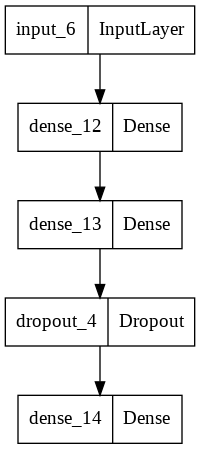

In [92]:
tf.keras.utils.plot_model(mlp)

In [ ]:
# Compiling the model
mlp_earlystop = EarlyStopping(patience = 20, min_delta = 0.001, monitor = 'val_acc')

path = 'mlp_checkpoint/checkpoint_{epoch:02d}';
mlp_checkpoint = ModelCheckpoint(filepath = path,
                            verbose = 1,
                            monitor = 'val_acc',
                            save_freq = 'epoch',
                            save_best_only = True,
                            save_weights_only = True)

mlp.compile(loss = 'categorical_crossentropy', metrics = ['acc'], optimizer = 'adam')

In [ ]:
mlp_history = mlp.fit(x_train, y_train,
                      validation_data = (x_temp, y_temp),
                      epochs = 100,
                      batch_size = 32,
                      shuffle = True,
                      callbacks = [mlp_earlystop, mlp_checkpoint],
                     ) #Fitting the model

Epoch 1/100
41/55 [=====================>........] - ETA: 0s - loss: 1.3615 - acc: 0.2912
Epoch 00001: val_acc improved from -inf to 0.36253, saving model to mlp_checkpoint/checkpoint_01
55/55 [==============================] - 2s 13ms/step - loss: 1.3556 - acc: 0.3006 - val_loss: 1.3085 - val_acc: 0.3625
Epoch 2/100
46/55 [========================>.....] - ETA: 0s - loss: 1.2985 - acc: 0.3512
Epoch 00002: val_acc improved from 0.36253 to 0.37601, saving model to mlp_checkpoint/checkpoint_02
55/55 [==============================] - 0s 8ms/step - loss: 1.2948 - acc: 0.3480 - val_loss: 1.2434 - val_acc: 0.3760
Epoch 3/100
51/55 [==========================>...] - ETA: 0s - loss: 1.2447 - acc: 0.3744
Epoch 00003: val_acc improved from 0.37601 to 0.38140, saving model to mlp_checkpoint/checkpoint_03
55/55 [==============================] - 0s 6ms/step - loss: 1.2427 - acc: 0.3734 - val_loss: 1.1803 - val_acc: 0.3814
Epoch 4/100
44/55 [=======================>......] - ETA: 0s - loss: 1.2086

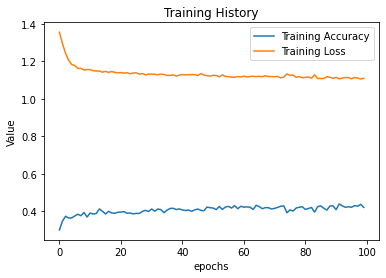

Initial training accuracy is:  0.3005780279636383
Final training accuracy is:  0.42080923914909363
Initial training loss is:  1.3556478023529053
Final training loss is:  1.1094460487365723


In [ ]:
#Plotting model history
plt.plot(mlp_history.history['acc'])
plt.plot(mlp_history.history['loss'])
plt.legend(['Training Accuracy', 'Training Loss'])
plt.title('Training History')
plt.ylabel('Value')
plt.xlabel('epochs')
plt.show()
print("Initial training accuracy is: ", mlp_history.history['acc'][0])
print("Final training accuracy is: ", mlp_history.history['acc'][-1])

print("Initial training loss is: ", mlp_history.history['loss'][0])
print("Final training loss is: ", mlp_history.history['loss'][-1])

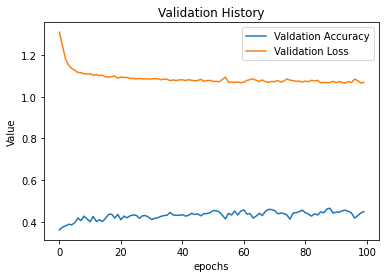

Initial validation accuracy is:  0.36253368854522705
Final validation accuracy is:  0.4501347839832306
Initial validation loss is:  1.3084759712219238
Final validation loss is:  1.0684932470321655


In [ ]:
#Plotting model history
plt.plot(mlp_history.history['val_acc'])
plt.plot(mlp_history.history['val_loss'])
plt.legend(['Valdation Accuracy', 'Validation Loss'])
plt.title('Validation History')
plt.ylabel('Value')
plt.xlabel('epochs')
plt.show()
print("Initial validation accuracy is: ", mlp_history.history['val_acc'][0])
print("Final validation accuracy is: ", mlp_history.history['val_acc'][-1])

print("Initial validation loss is: ", mlp_history.history['val_loss'][0])
print("Final validation loss is: ", mlp_history.history['val_loss'][-1])

## Feature Extract Model

In [ ]:
x

array([[ 9.02371982,  3.74238   , 12.72616877,  9.22876301],
       [11.08615172,  7.2494996 , 21.52443057, 14.28126423],
       [13.1138586 ,  7.29578872, 13.23728385,  6.3918014 ],
       ...,
       [ 1.18089195,  0.93442736,  2.23554018,  2.52324503],
       [ 0.97170381,  0.68291629,  1.55515726,  1.73322675],
       [ 3.25415824,  2.26377955,  1.53420759,  1.70690454]])

In [ ]:
x = np.expand_dims(x, -1)

In [ ]:
x.shape

(2472, 4, 1)

In [ ]:
dims_lstm_1 = 4
dims_lstm_2 = 1

In [ ]:
print(x.shape)
print(y.shape)

(2472, 4, 1)
(2472, 4)


In [ ]:
x_train,x_temp,y_train,y_temp = train_test_split(x,y,test_size=0.30)

In [90]:
inp_shape = (dims_lstm_1, dims_lstm_2)
ip = tf.keras.Input(shape = inp_shape)
conv1 = tf.keras.layers.Conv1D(32, 3, activation = 'relu')(ip)
conv1 = tf.keras.layers.ZeroPadding1D(padding=1)(conv1)
# rel1 = tf.keras.layers.LeakyReLU()(conv1)
# maxpool1 = tf.keras.layers.MaxPooling1D()(conv1)
skip1 = conv1
conv2 = tf.keras.layers.Conv1D(32, 3, activation = 'relu')(conv1)
conv2 = tf.keras.layers.ZeroPadding1D(padding=1)(conv2)
# rel2 = tf.keras.layers.LeakyReLU()(conv2)
# maxpool2 = tf.keras.layers.MaxPooling1D()(conv2)
# maxpool2 = tf.keras.layers.ZeroPadding1D(padding=(44,43))(maxpool2)
skip2 = conv2
conv3 = tf.keras.layers.Conv1D(32, 3, activation = 'relu')(conv2)
conv3 = tf.keras.layers.ZeroPadding1D(padding=1)(conv3)
# conv4 = tf.keras.layers.Conv1D(32,)(conv3)
# conv4 = tf.keras.layers.ZeroPadding1D(padding=1)(conv4)
# conv5 = tf.keras.layers.Conv1D(32,)(conv4)
# conv5 = tf.keras.layers.ZeroPadding1D(padding=1)(conv5)
# maxpool5 = tf.keras.layers.MaxPooling1D()(conv5)
# maxpool5 = tf.keras.layers.ZeroPadding1D(padding=(44, 43))(maxpool5)
addlayer1 = tf.keras.layers.Add()([skip1, skip2, conv3])

# lstm = tf.keras.layers.LSTM(16, return_sequences=True)(ip)
flatten = tf.keras.layers.Flatten()(addlayer1)
dense1 = tf.keras.layers.Dense(units = 32, kernel_initializer = 'random_normal')(flatten)
# leakyRelu = tf.keras.layers.LeakyReLU()(dense1)
# drop1 = tf.keras.layers.Dropout(.4)(dense1)
dense2 = tf.keras.layers.Dense(units = 16, kernel_initializer = 'random_normal')(dense1)
# leakyRelu2 = tf.keras.layers.LeakyReLU()(dense2)
drop2 = tf.keras.layers.Dropout(.4)(dense2)
out = tf.keras.layers.Dense(num_classes, activation = 'softmax')(drop2)

ftExtract = tf.keras.Model(inputs = ip, outputs = out)
ftExtract.summary()

Model: "model_3"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_5 (InputLayer)           [(None, 4, 1)]       0           []                               
                                                                                                  
 conv1d_8 (Conv1D)              (None, 2, 32)        128         ['input_5[0][0]']                
                                                                                                  
 zero_padding1d_6 (ZeroPadding1  (None, 4, 32)       0           ['conv1d_8[0][0]']               
 D)                                                                                               
                                                                                                  
 conv1d_9 (Conv1D)              (None, 2, 32)        3104        ['zero_padding1d_6[0][0]'] 

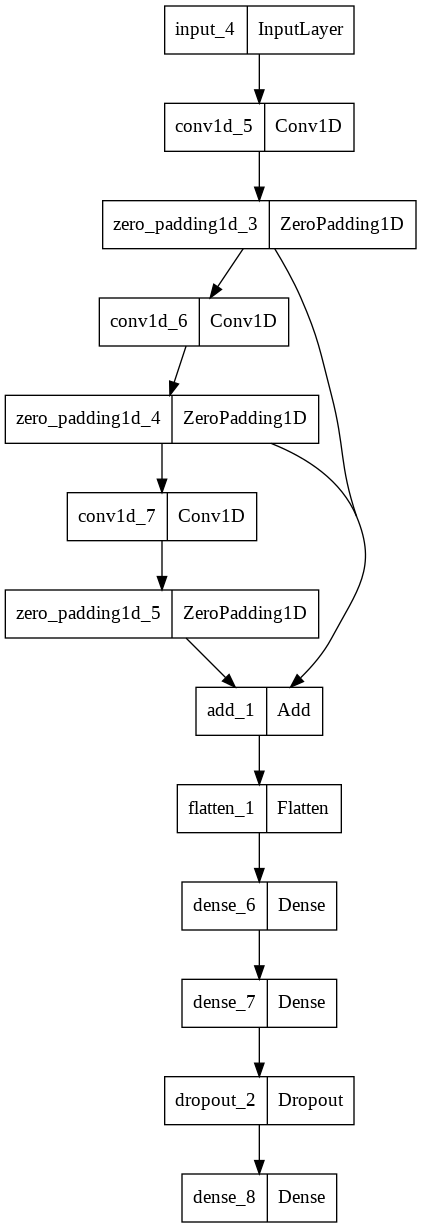

In [89]:
tf.keras.utils.plot_model(ftExtract)

In [ ]:
# Compiling the model
fte_earlystop = EarlyStopping(patience = 15, min_delta = 0.001, monitor = 'val_acc')

path = 'fte_checkpoint/checkpoint_{epoch:02d}';
fte_checkpoint = ModelCheckpoint(filepath = path,
                            verbose = 1,
                            monitor = 'val_acc',
                            save_freq = 'epoch',
                            save_best_only = True,
                            save_weights_only = True)

ftExtract.compile(loss = 'categorical_crossentropy', metrics = ['acc'], optimizer = 'adam')

In [ ]:
ftExtract_history = ftExtract.fit(x_train, y_train,
                      validation_data = (x_temp, y_temp),
#                         steps_per_epoch= 449,
                        batch_size = 32,
                        epochs = 100,
                        callbacks = [fte_checkpoint],
                    ) #Fitting the model

Epoch 1/100
53/55 [===========================>..] - ETA: 0s - loss: 1.3181 - acc: 0.3208
Epoch 00001: val_acc improved from -inf to 0.37736, saving model to fte_checkpoint/checkpoint_01
55/55 [==============================] - 1s 8ms/step - loss: 1.3162 - acc: 0.3208 - val_loss: 1.1859 - val_acc: 0.3774
Epoch 2/100
51/55 [==========================>...] - ETA: 0s - loss: 1.2166 - acc: 0.3738
Epoch 00002: val_acc improved from 0.37736 to 0.38544, saving model to fte_checkpoint/checkpoint_02
55/55 [==============================] - 0s 5ms/step - loss: 1.2188 - acc: 0.3676 - val_loss: 1.1451 - val_acc: 0.3854
Epoch 3/100
54/55 [============================>.] - ETA: 0s - loss: 1.1704 - acc: 0.3796
Epoch 00003: val_acc improved from 0.38544 to 0.41240, saving model to fte_checkpoint/checkpoint_03
55/55 [==============================] - 0s 4ms/step - loss: 1.1703 - acc: 0.3798 - val_loss: 1.1144 - val_acc: 0.4124
Epoch 4/100
52/55 [===========================>..] - ETA: 0s - loss: 1.1631 

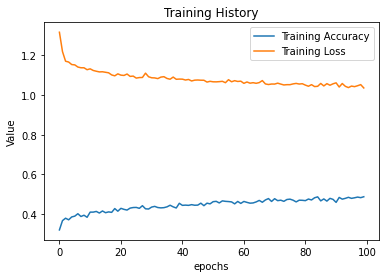

Initial training accuracy with preprocessing is:  0.3208092451095581
Final training accuracy with preprocessing is:  0.4878612756729126
Initial training loss with preprocessing is:  1.3162490129470825
Final training loss with preprocessing is:  1.0357197523117065


In [ ]:
#Plotting model history
plt.plot(ftExtract_history.history['acc'])
plt.plot(ftExtract_history.history['loss'])
plt.legend(['Training Accuracy', 'Training Loss'])
plt.title('Training History')
plt.ylabel('Value')
plt.xlabel('epochs')
plt.show()
print("Initial training accuracy with preprocessing is: ", ftExtract_history.history['acc'][0])
print("Final training accuracy with preprocessing is: ", ftExtract_history.history['acc'][-1])

print("Initial training loss with preprocessing is: ", ftExtract_history.history['loss'][0])
print("Final training loss with preprocessing is: ", ftExtract_history.history['loss'][-1])

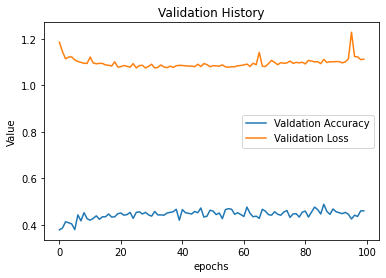

Initial Validation accuracy with preprocessing is:  0.37735849618911743
Final Validation accuracy with preprocessing is:  0.45956873893737793
Initial Validation loss with preprocessing is:  1.1858807802200317
Final Validation loss with preprocessing is:  1.1129980087280273


In [ ]:
#Plotting model history
plt.plot(ftExtract_history.history['val_acc'])
plt.plot(ftExtract_history.history['val_loss'])
plt.legend(['Valdation Accuracy', 'Validation Loss'])
plt.title('Validation History')
plt.ylabel('Value')
plt.xlabel('epochs')
plt.show()
print("Initial Validation accuracy with preprocessing is: ", ftExtract_history.history['val_acc'][0])
print("Final Validation accuracy with preprocessing is: ", ftExtract_history.history['val_acc'][-1])

print("Initial Validation loss with preprocessing is: ", ftExtract_history.history['val_loss'][0])
print("Final Validation loss with preprocessing is: ", ftExtract_history.history['val_loss'][-1])